# Проект "Банки — Сегментация пользователей по потреблению"

**Заказчик**: отдел банковских продуктов регионального банка

**Цель**: Уменьшение оттока клиентов. Нужно сегментировать пользователей, чтобы выявить группы более склонные к оттоку. Описать сегменты и дать рекомендации по удержанию.

**Задача**:

- Сегментировать пользователей на основе данных, по набору признаков: количество потребляемых продуктов, возраст, пол, город проживания, доход, наличие кредитной карты, кредитный рейтинг.  
- Проверить статистические гипотезы:
    - Гипотезу различия дохода между теми клиентами, которые пользуются однии и двуми продуктами банка,
    - Отток в одном из городов больше чем в остальных.  
- Описать сегменты, дать рекомендации. 

## Загрузка и предобработка данных

### Описание данных

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

### Чтение данных

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

In [2]:
df = pd.read_csv('/datasets/bank_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


12 столбцов, 10000 строк. Пропуски в столбце Баланс. Стоит привести наименования к нижнему регистру.

In [3]:
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


Типы данных соответствуют содержимому. По факту логический тип данных в столбцах: CreditCard, Loyalty, Churn. И стоит заменить в столбце Gender текстовое обозначение пола на 1/0.

### Преобразование типов , переименование

In [4]:
# наименования столбцов приводим к нижнему регистру
df.columns = df.columns.str.lower()
df.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

В столбце Пол: заменим значения М и Ж на 1 и 0 - так удобнее строить графики корреляции. Сделаем это в отдельном столбце.  

In [5]:
# добавляем столбец для пола, где вместо текста пол закодирован как 1/0
df['man'] = 1
df['man'] = df['man'].where(df['gender'] == 'М', 0)
# проверяем
display(df.sample(3))
df.groupby('gender').mean()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man
3057,15641576,680,Ярославль,М,33,1,123082.08,1,1,0,134960.98,0,1
7191,15610575,501,Ярославль,М,42,9,114631.23,1,0,1,91429.74,0,1
2776,15727845,689,Ярославль,М,39,7,NaN,2,0,0,14917.09,0,1


,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man
gender,,,,,,,,,,,
Ж,1.573388e+07,650.831389,39.238389,4.966102,118975.601938,1.544134,0.702619,0.502751,100601.541382,0.250715,0.0
М,1.573350e+07,650.276892,38.658237,5.051677,120531.877184,1.518600,0.707898,0.525380,99664.576931,0.164559,1.0


В столбце Город тоже желательно заменить текст на цифры (или создать новый столбец город_id).

In [6]:
# смотрим наименования в столбце
df['city'].unique()

array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object)

In [7]:
# определяем функцию для замены наименования на id
def city_cat(cell):
    """
    принимает на вход наименование города и возвращает id:
    1 - Ярославль,
    2 - Рыбинск,
    3 - Ростов Великий,
    0 - в остальных случаях.
    """
    id = 0
    if cell == 'Ярославль':
        id = 1
    elif cell == 'Рыбинск':
        id = 2
    elif cell == 'Ростов Великий':
        id = 3
    else:
        id = 0
    return id

In [8]:
# создаем столбец с `id` города
df['city_id'] = df['city'].apply(city_cat)
# проверяем результат
display(df.sample(3))
df.groupby('city').mean()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id
8515,15854125,724,Ростов Великий,Ж,35,0,171982.95,2,0,1,167313.07,0,0,3
8612,15823452,686,Ростов Великий,М,39,3,129626.19,2,1,1,103220.56,0,1,3
2873,15749925,667,Ростов Великий,Ж,36,1,114391.62,1,1,1,53412.54,0,0,3


,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id
city,,,,,,,,,,,,
Ростов Великий,1.573329e+07,651.453567,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0.324432,0.524512,3.0
Рыбинск,1.573465e+07,651.333872,38.890997,5.032297,119814.985923,1.539362,0.694792,0.529673,99440.572281,0.166734,0.560355,2.0
Ярославль,1.573339e+07,649.668329,38.511767,5.004587,119927.765597,1.530913,0.706621,0.516753,99899.180814,0.161548,0.549063,1.0


### Дубликаты, ошибки

Проверяем наличие дубликатов.  

In [9]:
# количество полных дубликатов
print(df.duplicated().sum())
# дубликаты без номера id клиента
df.duplicated(subset=['score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn']).sum()

0


0

Дубликатов не нашли.

Смотрим на распределение значений в числовых столбцах и уникальные значения категориальных столбцов на наличие возможных ошибок и правдоподобность.

In [10]:
df.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,0,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,0,2
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,0,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,0,1
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,0,2


In [11]:
df.describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700,0.545700,1.749500
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769,0.497932,0.830433
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,1.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000,1.000000,1.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,3.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,3.000000


В числовых столбцах минимальные и максимальные значения выглядят правдоподобно. Разве что минимальный доход в 11,58 кажется странным. Отрицательных значений нет, экстремально высоких тоже нет. Ок.

In [12]:
# выводим уникальные значения всех столбцов типа `объект`
cols_cat = df.select_dtypes(include=['object'])
for col in cols_cat.columns:
    print(df[col].unique())

['Ярославль' 'Рыбинск' 'Ростов Великий']
['Ж' 'М']


В категориальных столбцах ошибок также нет.

### Обработка пропусков

In [13]:
len(df[df['balance'].isna()]) / len(df)

0.3617

Информация о текущем балансе клиента пропущена в 36% строк.

Смотрим корреляцию признаков с пропусками, определяем причину, заполняем/оставляем.

In [14]:
# смотрим характеристики таблицы где пропущена информация о балансе
df[df['balance'].isna()].describe(include='all')

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id
count,3.617000e+03,3617.000000,3617,3617,3617.000000,3617.000000,0.0,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000
unique,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ярославль,М,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,2418,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.573469e+07,649.452861,NaN,NaN,38.434891,5.071330,NaN,1.784628,0.716616,0.517832,98983.559549,0.138236,0.542715,1.331490
std,7.194749e+04,96.158798,NaN,NaN,10.492002,2.860781,NaN,0.496455,0.450704,0.499751,57730.828955,0.345195,0.498241,0.470814
min,1.560844e+07,350.000000,NaN,NaN,18.000000,0.000000,NaN,1.000000,0.000000,0.000000,90.070000,0.000000,0.000000,1.000000
25%,1.567226e+07,583.000000,NaN,NaN,31.000000,3.000000,NaN,1.000000,0.000000,0.000000,49506.820000,0.000000,0.000000,1.000000
50%,1.573608e+07,651.000000,NaN,NaN,37.000000,5.000000,NaN,2.000000,1.000000,1.000000,98618.790000,0.000000,1.000000,1.000000
75%,1.579629e+07,717.000000,NaN,NaN,43.000000,7.000000,NaN,2.000000,1.000000,1.000000,148330.970000,0.000000,1.000000,2.000000


In [15]:
# смотрим на часть таблицы, где нет пропусков в балансе
df[~df['balance'].isna()].describe(include='all')

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id
count,6.383000e+03,6383.000000,6383,6383,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000,6383.000000
unique,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ярославль,М,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,2596,3494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.573310e+07,651.138493,NaN,NaN,39.197713,4.979633,119827.493793,1.386025,0.699201,0.513552,100717.352956,0.240796,0.547392,1.986370
std,7.192913e+04,96.934609,NaN,NaN,10.476208,2.909514,30095.056462,0.577011,0.458641,0.499855,57380.316584,0.427600,0.497788,0.894271
min,1.560844e+07,350.000000,NaN,NaN,18.000000,0.000000,3768.690000,1.000000,0.000000,0.000000,11.580000,0.000000,0.000000,1.000000
25%,1.567094e+07,584.000000,NaN,NaN,32.000000,2.000000,100181.975000,1.000000,0.000000,0.000000,51736.850000,0.000000,0.000000,1.000000
50%,1.573226e+07,652.000000,NaN,NaN,38.000000,5.000000,119839.690000,1.000000,1.000000,1.000000,101139.300000,0.000000,1.000000,2.000000
75%,1.579584e+07,718.000000,NaN,NaN,44.000000,8.000000,139512.290000,2.000000,1.000000,1.000000,149596.615000,0.000000,1.000000,3.000000


Как видим из значения количества уникальных признаков столбца `city`, пропуски есть в данных только двух городов.

In [16]:
df[df['balance'].isna()]['city'].unique()

array(['Ярославль', 'Рыбинск'], dtype=object)

Только в Ростове в данных никогда нет пропусков в значении баланса.

In [17]:
# нет данных о балансе у числа клиентов
df[df['balance'].isna()].groupby('city')['userid'].count()

city
Рыбинск      1199
Ярославль    2418
Name: userid, dtype: int64

In [18]:
# всего клиентов по городам
df.groupby('city')['userid'].count()

city
Ростов Великий    2509
Рыбинск           2477
Ярославль         5014
Name: userid, dtype: int64

In [19]:
# доля пропусков по городам
df[df['balance'].isna()].groupby('city')['userid'].count() / df.groupby('city')['userid'].count()

city
Ростов Великий         NaN
Рыбинск           0.484053
Ярославль         0.482250
Name: userid, dtype: float64

Фактически у нас нет информации о балансе половины клиентов в двух городах: Ярославле и Рыбинске. По Ростову Великому у нас пропусков нет. Возможно стоит анализировать эти города по отдельности.

In [20]:
df.groupby('city').mean()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id
city,,,,,,,,,,,,
Ростов Великий,1.573329e+07,651.453567,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0.324432,0.524512,3.0
Рыбинск,1.573465e+07,651.333872,38.890997,5.032297,119814.985923,1.539362,0.694792,0.529673,99440.572281,0.166734,0.560355,2.0
Ярославль,1.573339e+07,649.668329,38.511767,5.004587,119927.765597,1.530913,0.706621,0.516753,99899.180814,0.161548,0.549063,1.0


Если взять средние значения всех показателей по городам, то бросается в глаза высокий уровень оттока в Ростове Великом. Он тут в два раза выше чем в двух других городах: 32 против 16%.

Пропуски в столбце с балансом карты не мешают, пока оставим.

## Исследовательский анализ данных

### Категоризация

Разобьем клиентов на категории по возрастным группам.  

In [228]:
df['age_cat'] = pd.cut((df['age']), [0,30,40,50,60,70,100])
df.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id,age_cat,product_segment,age_segment,city_segment,gender_segment,segment_sum
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,0,1,"(40, 50]",B,D,A,B,BDB
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,0,2,"(40, 50]",B,D,B,B,BDB
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,0,1,"(40, 50]",C,D,A,B,C
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,0,1,"(30, 40]",A,B,A,B,ABB
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,0,2,"(40, 50]",B,D,B,B,BDB


In [229]:
print('Размер категории:', df.groupby('age_cat').userid.count())
print()
print('средние значения по категории:')
display(df.groupby('age_cat').mean())
print()
print('средний отток по категории:')
print(df.groupby('age_cat').churn.mean())

Размер категории: age_cat
(0, 30]      1968
(30, 40]     4451
(40, 50]     2320
(50, 60]      797
(60, 70]      331
(70, 100]     133
Name: userid, dtype: int64

средние значения по категории:


,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id
age_cat,,,,,,,,,,,,
"(0, 30]",1.573158e+07,651.200711,26.602642,5.077236,120246.383681,1.555386,0.711382,0.511179,101089.999959,0.075203,0.552846,1.702744
"(30, 40]",1.573426e+07,651.391148,35.560324,5.012806,119979.153399,1.534262,0.711975,0.497641,99359.311804,0.120872,0.559874,1.710402
"(40, 50]",1.573379e+07,648.794397,44.594828,4.984914,119663.291284,1.528017,0.694828,0.471552,102047.043353,0.339655,0.525862,1.832328
"(50, 60]",1.573526e+07,646.761606,54.956085,4.997491,119407.500982,1.464241,0.685069,0.578419,97150.934015,0.562108,0.509410,1.844417
"(60, 70]",1.573207e+07,651.223565,64.574018,4.851964,119061.011461,1.507553,0.700906,0.767372,97545.985196,0.314199,0.555891,1.755287
"(70, 100]",1.573766e+07,662.827068,74.819549,5.037594,116284.656667,1.511278,0.721805,0.909774,99570.120000,0.082707,0.503759,1.721805



средний отток по категории:
age_cat
(0, 30]      0.075203
(30, 40]     0.120872
(40, 50]     0.339655
(50, 60]     0.562108
(60, 70]     0.314199
(70, 100]    0.082707
Name: churn, dtype: float64


Размеры категорий неравны, но они сильно отличаются по доле оттока, поэтому мне бы не хотелось пока объединять группы.

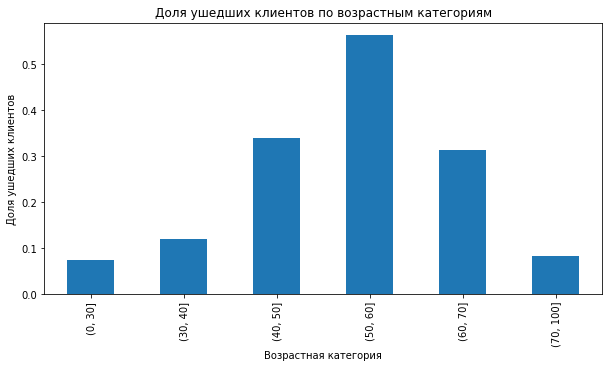

In [230]:
plt.figure(figsize=(10, 5))
df.groupby('age_cat').churn.mean().plot(kind='bar')
plt.title('Доля ушедших клиентов по возрастным категориям')

plt.ylabel('Доля ушедших клиентов')
plt.xlabel('Возрастная категория')
plt.show()

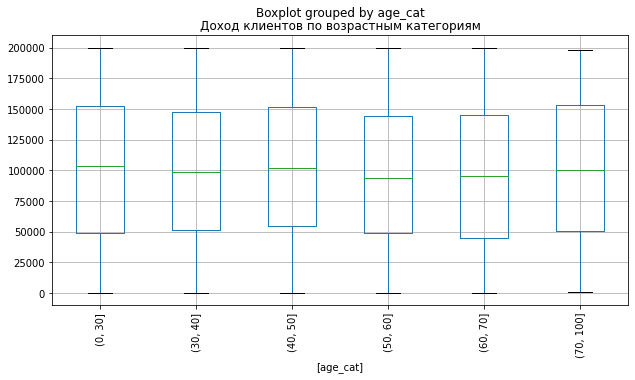

In [233]:
df.boxplot(column=['estimated_salary'], by=['age_cat'],
          rot=90, figsize=(10,5))
plt.title('Доход клиентов по возрастным категориям')
plt.show()

Доходы внутри возрастных категорий странным образом не сильно различаются.

### Распределение признаков

#### Отток

##### Корреляция признаков

Посмотрим на то как зависит отток клиентов от различных признаков: пол, возрастная категория, город проживания и т.д.

In [25]:
df.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn', 'man',
       'city_id', 'age_cat'],
      dtype='object')

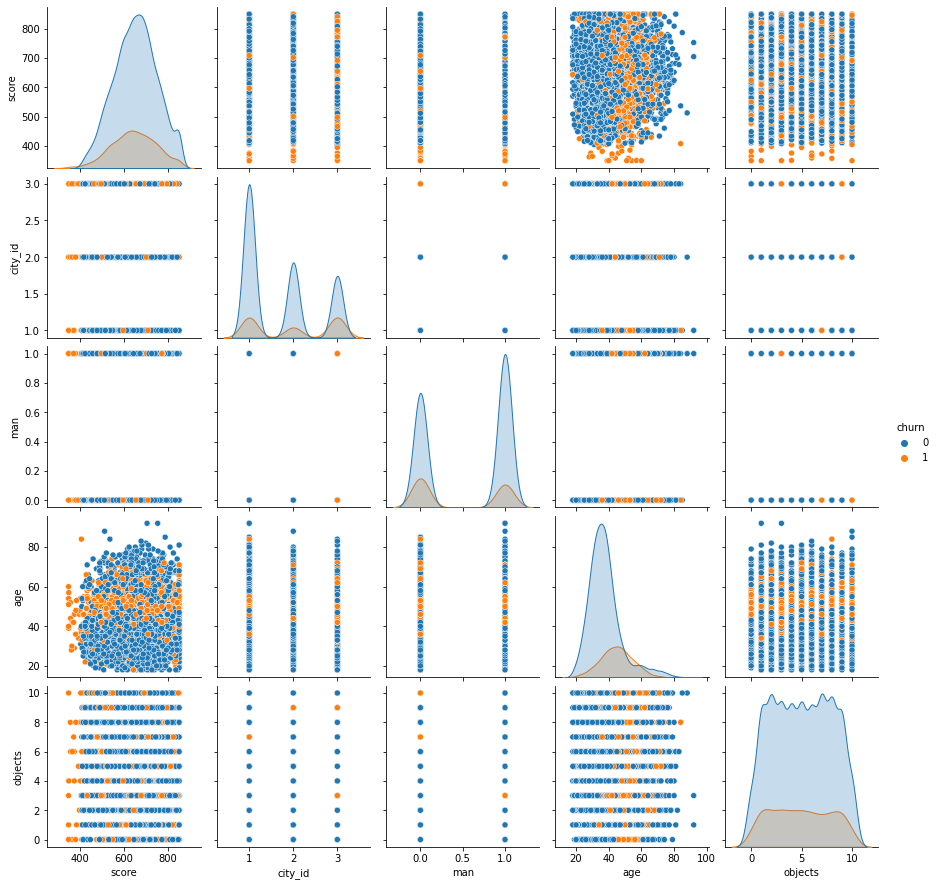

In [26]:
# строим матрицу рассеяния для первых пяти признаков с разбивкой на две группы отсев/остальные
sns.pairplot(df[['score', 'city_id', 'man', 'age', 'objects'] + ['churn']], hue='churn'); 

Наиболее заметна корреляция оттока с возрастом: самое большое число клиентов с признаком оттока в возрасте от 40 до 60 лет,
также попадают в отток клиенты с кредитным рейтингом ниже 400. При этом видим, что в Ростове (город №3) также заметен отток при кредитном рейтинге выше 700.

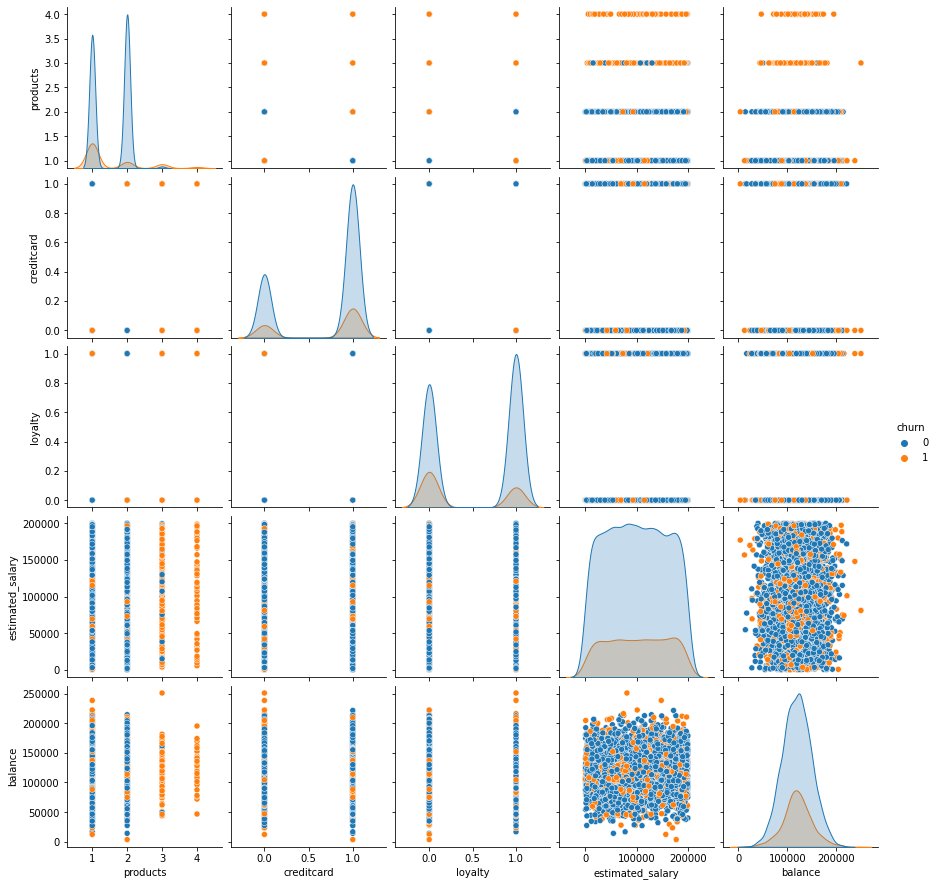

In [27]:
# строим матрицу рассеяния для других пяти признаков с разбивкой на две группы отсев/остальные
sns.pairplot(df[['products', 'creditcard', 'loyalty', 'estimated_salary', 'balance'] + ['churn']], hue='churn'); 

Также высокая корреляция с оттоком у признака количества продуктов: клиенты с количеством банковских продуктов 3 и 4 почти полностью попадают в отток.

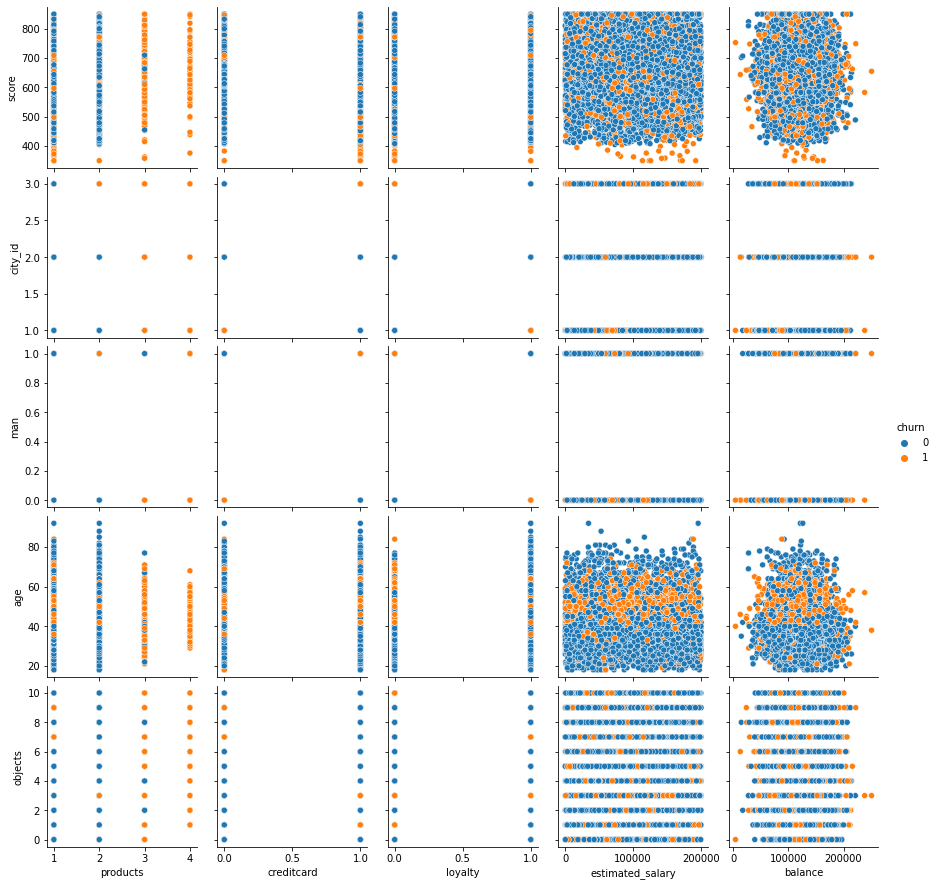

In [28]:
# строим матрицу рассеяния для остальных признаков с разбивкой на две группы отсев/остальные
sns.pairplot(df,
             x_vars=df[['products', 'creditcard', 'loyalty', 'estimated_salary', 'balance']],
             y_vars=df[['score', 'city_id', 'man', 'age', 'objects']], hue='churn'); 

Здесь мы видим, что в отток попадают в городе №3 (Ростов) клиенты с более высоким уровнем дохода чем в других городах.

##### Пол

Обычно пол клиента влияет на его поведение, но выше мы не увидели корреляции. Посмотрим на цифры оттока с разбивкой по полу.

In [235]:
# показатель оттока в разбивке по городу, количеству продуктов и полу
cm = sns.light_palette("orange", as_cmap=True)
print('Доля оттока в группах с разбивкой на число продуктов и пол по городам')
df.pivot_table(
    index='city',
    columns=['products', 'gender'],
    values='churn',
    aggfunc='mean',
    margins=True
).style.background_gradient(cmap=cm, axis=None)

Доля оттока в группах с разбивкой на число продуктов и пол по городам


Отток среди женщин заметно выше: 33% в группе с 1 одним продуктом - против 23% среди мужчин, 10% против 5% в группе с 2 продуктами и 86% против 77% в группе с 3 продуктами.  
Т.е. среди самых лояльных клиентов отток среди женщин выше в два раза чем среди мужчин и в группе среднего риска отток женщин на 50% выше мужчин.  
Такая картина характерна для всех городов.

In [234]:
# показатель оттока в разбивке по возрасту, количеству продуктов и полу
cm = sns.light_palette("orange", as_cmap=True)

df.pivot_table(
    index='age_cat',
    columns=['products', 'gender'],
    values='churn',
    aggfunc='mean',
    margins=True
).style.background_gradient(cmap=cm, axis=None)

Если мы учитываем возраст, то видно, что среди самых лояльных клиентов 2 группы женщины в возрасте от 40 до 60 показывают уровень оттока выше среднего, а в группе среднего риска (с 1 продуктом) - женщины уходят раньше мужчин - с 30 до 70 лет - уровнь оттока здесь также выше среднего (20%). Мужчины превышают средний показатель оттока здесь от 40 до 70 лет.

Делаем выводы о влиянии признаков на отток.  
Наиболее характерные признаки группы оттока: женщины, возраст от 40 до 60, количество банковских продуктов 3 или 4 и клиенты ростовского отделения, кредитный рейтинг ниже 400.

#### Признаки по городам

Посмотрим как распределены признаки в городах.

##### Число продуктов

In [31]:
print('Доля оттока по городам с разбивкой по числу продуктов')
cm = sns.light_palette("orange", as_cmap=True)

df.pivot_table(
    index='products',
    columns=['city'],
    values='churn',
    aggfunc='mean',
    margins=True
).style.background_gradient(cmap=cm, axis=None)

Доля оттока по городам с разбивкой по числу продуктов


city,Ростов Великий,Рыбинск,Ярославль,All
products,,,,
1,0.428466,0.218673,0.224344,0.277144
2,0.121154,0.073542,0.057034,0.075817
3,0.895833,0.787879,0.788462,0.827068
4,1.000000,1.000000,1.000000,1.000000
All,0.324432,0.166734,0.161548,0.203700


Средний уровень оттока 20%, Ростов Великий лидирует по этому показателю на всех продуктах. Особенно большой отрыв на первом продукте 42% проитв 22% в остальных городах.

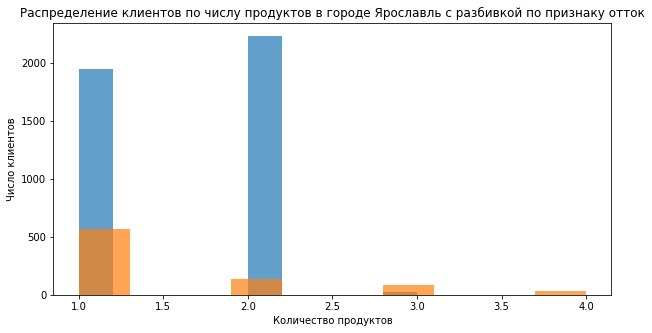

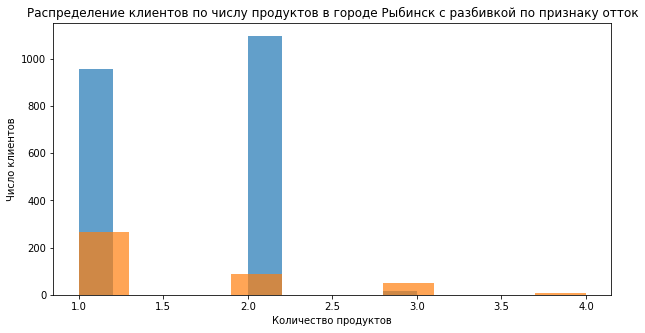

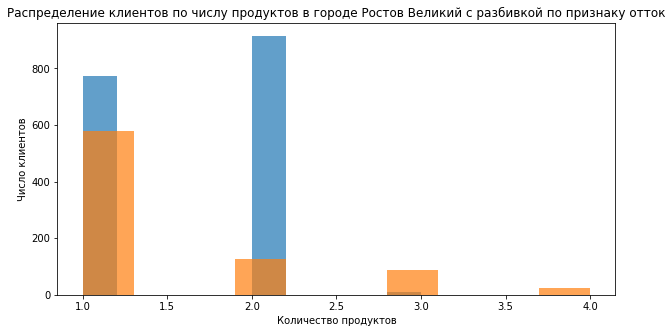

In [32]:
# строим гистограмму распределения числа продуктов для каждого города с разбивкой на ушедших/оставшихся клиентов
for city in df.city.unique():
    
    plt.figure(figsize=(10, 5))
    df[df['city'] == city].groupby('churn').products.plot(kind='hist', alpha=0.7)
    plt.title('Распределение клиентов по числу продуктов в городе {} с разбивкой по признаку отток'.format(city))
    plt.ylabel('Число клиентов')
    plt.xlabel('Количество продуктов')
    plt.show()

Во всех городах клиенты уходят на 3-4-ом продуктах. Для Ростова характерен высокий отток клиентов уже на первом продукте.  
При этом по числу клиентов группы 1 и 2 самые крупные. Если повысить удержание клиентов этих групп это даст наибольший эффект.

##### Кредитный рейтинг

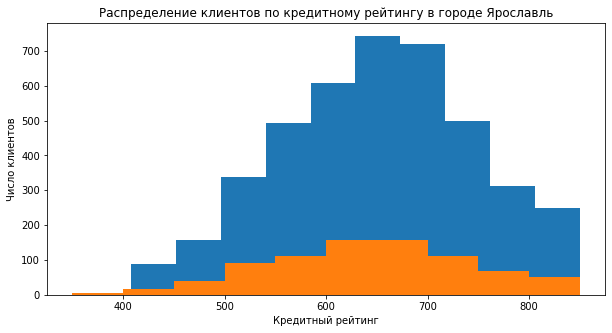

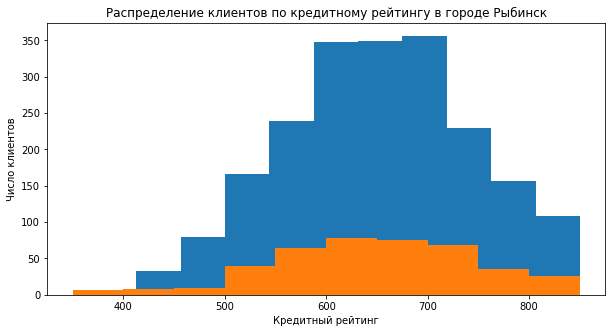

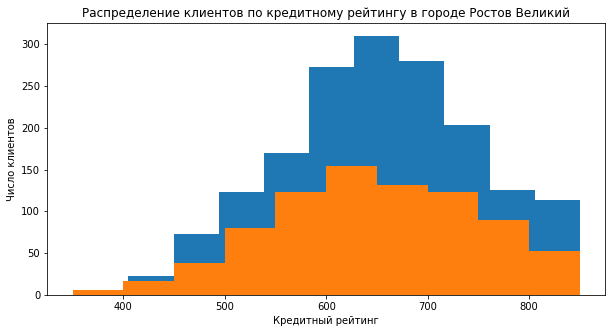

In [227]:
# для каждого города смотрим распределение кредитного рейтинга с разбивкой по оттоку
for city in df.city.unique():
    
    plt.figure(figsize=(10, 5))
    df[df['city'] == city].groupby('churn').score.plot(kind='hist')
    plt.title('Распределение клиентов по кредитному рейтингу в городе {}'.format(city))
    plt.ylabel('Число клиентов')
    plt.xlabel('Кредитный рейтинг')
    plt.show()

В Ростове Великом отсеивается очень много клиентов, в том числе с высокими значениями кредитного рейтинга.

##### Возраст

In [283]:
print('Доля оттока по городам с разбивкой по возрасту')
cm = sns.light_palette("orange", as_cmap=True)

df.pivot_table(
    index='age_cat',
    columns=['city'],
    values='churn',
    aggfunc='mean',
    margins=True
).style.background_gradient(cmap=cm, axis=None, low=0)

Доля оттока по городам с разбивкой по возрасту


city,Ростов Великий,Рыбинск,Ярославль,All
age_cat,,,,
"(0, 30]",0.123620,0.085954,0.049133,0.075203
"(30, 40]",0.209393,0.093023,0.095197,0.120872
"(40, 50]",0.488201,0.273043,0.281162,0.339655
"(50, 60]",0.695473,0.459893,0.525886,0.562108
"(60, 70]",0.500000,0.244444,0.260870,0.314199
"(70, 100]",0.121212,0.100000,0.057143,0.082707
All,0.324432,0.166734,0.161548,0.203700


Похоже, что в Ростове Великом особенно катастрафично выглядит отток в средней возрастной группе: старше 40 лет.

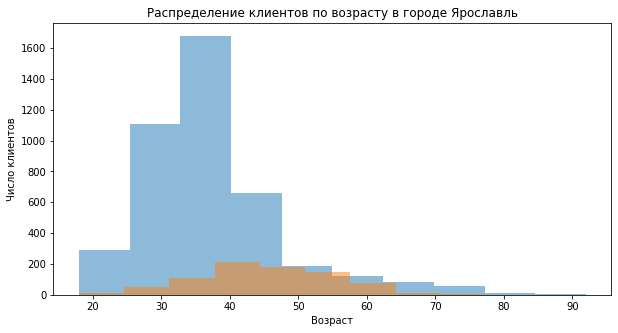

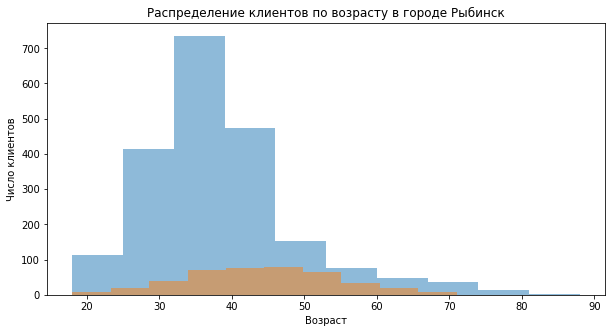

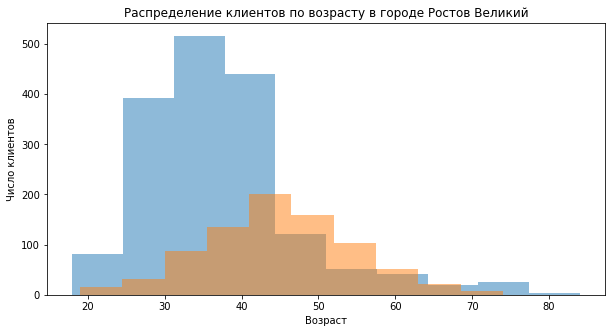

In [35]:
for city in df.city.unique():
    
    plt.figure(figsize=(10, 5))
    df[df['city'] == city].groupby('churn').age.plot(kind='hist', alpha=0.5)
    plt.title('Распределение клиентов по возрасту в городе {}'.format(city))
    plt.ylabel('Число клиентов')
    plt.xlabel('Возраст')
    plt.show()

Для Ярославля характерно резкое снижение числа клиентов старше 48 лет, при этом в отток попадает половина клиентов старше этого возраста.  

В Ростове Великом число уходящих клиентов старше 45 лет выше числа остающихся.  
При этом основная масса клиентов моложе этого возраста.

## Сегментация пользователей

Разбиваем клиентов на сегменты по набору признаков, которые мы посчитали релевантными для оттока: число продуктов, возраст, пол и город.

### Число продуктов

Так как мы выявили высокую корреляцию между оттоком и количеством продуктов клиента, то будем сегментировать клиентов по этому признаку. Наименьший отток в группе с 2-я продуктами (сегмент с самым низким риском оттока) - А, наибольший отток в группах с количеством продуктов 3-4 (С) и средний в группе с 1-м продуктом (Б).

In [36]:
# записываем наименование сегмента в отдельный столбец
dic = {1: 'B', 2: 'A', 3: 'C', 4: 'C'}
df['product_segment'] = df['products'].map(dic)
df.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id,age_cat,product_segment
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,0,1,"(40, 45]",B
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,0,2,"(40, 45]",B
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,0,1,"(40, 45]",C
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,0,1,"(35, 40]",A
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,0,2,"(40, 45]",B


In [37]:
# смотрим количество клиентов в группах
df.groupby('product_segment').userid.count()

product_segment
A    4590
B    5084
C     326
Name: userid, dtype: int64

Группы получились неравные, в самой маленькой группе с самым высоким риском оттока всего 326 клиентов.

In [38]:
# средние значения признаков в сегментах
df.groupby('product_segment').mean()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id
product_segment,,,,,,,,,,,,
A,1.573484e+07,652.188671,37.753595,5.051852,119660.944362,2.000000,0.707190,0.532898,100452.012821,0.075817,0.551198,1.710893
B,1.573237e+07,649.120968,39.673092,4.974626,119894.163723,1.000000,0.703777,0.504131,99487.256851,0.277144,0.548387,1.770850
C,1.573768e+07,649.113497,43.653374,5.058282,120074.314953,3.184049,0.708589,0.435583,104400.141503,0.858896,0.426380,1.960123


Сегмент А имеет самый низкий процент ушедших клиентов - 7,5%, средний возраст 37,7 лет, 2 подключенных банковских продукта, средний доход 100 тысяч, доля мужчин чуть выше других групп - 55%.  
Сегмент Б (клиенты с 1 продуктом) имеет средний уровень оттока - 27,7%, средний возраст 39,7 лет, среднюю лояльность 0,5, средний доход 99 тысяч, доля мужчин 54,8%.  
Сегмент С (клиенты с 3-4 продуктами) - уровень оттока 85,8%, средний возраст - выше других групп 43,6%, более низкая средняя лояльность - 0,43, более высокий доход среди сегментов - 104 тысячи, доля мужчин ниже остальных групп - 42,6%. 

### Возраст

Мы знаем, что второй существенный признак, влияющий на отток это возраст. Выделим возрастные группы для сегментации.  
Ранее мы определили, что с 35 лет показатель оттока начинает превышать среднее значение в 20%, становится максимальным на промежутке от 40 до 65 и затем снижается.  
Наименования сегментов отражают уровень оттока в группе, поэтому группа 40-65 получает D, а более старшая группа 65+ имя C.

In [39]:
# записываем наименование сегмента в отдельный столбец
df['age_segment'] = pd.cut(df['age'], [0,35,40,65,100], labels=['A', 'B', 'D', 'C'])
df['age_segment'] = df['age_segment'].astype('object')
df.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id,age_cat,product_segment,age_segment
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,0,1,"(40, 45]",B,D
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,0,2,"(40, 45]",B,D
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,0,1,"(40, 45]",C,D
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,0,1,"(35, 40]",A,B
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,0,2,"(40, 45]",B,D


In [40]:
# смотрим количество клиентов в группах
df.groupby('age_segment').userid.count()

age_segment
A    4153
B    2266
C     264
D    3317
Name: userid, dtype: int64

Получили 4 группы от 400 до 4000 клиентов.

In [41]:
# средние значения признаков в сегментах
df.groupby('age_segment').mean()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id
age_segment,,,,,,,,,,,,
A,1.573278e+07,650.594028,30.009150,5.049603,119970.531396,1.541055,0.714905,0.511678,100080.471654,0.083554,0.558873,1.700939
B,1.573465e+07,652.686673,37.954545,5.001324,120218.363075,1.540159,0.706090,0.483672,99540.696372,0.149603,0.555605,1.721094
C,1.573424e+07,664.143939,71.250000,5.090909,118421.194403,1.522727,0.708333,0.878788,99943.616894,0.132576,0.545455,1.738636
D,1.573409e+07,647.889358,48.168526,4.968345,119510.895225,1.510401,0.693096,0.511908,100489.558996,0.396744,0.522460,1.830570


Уровень оттока растет от А до D: от 8% до 39% в среднем по группе.

### Город

In [42]:
# записываем наименование сегмента в отдельный столбец
dic = {1: 'A', 2: 'B', 3: 'C'}
df['city_segment'] = df['city_id'].map(dic)
df.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id,age_cat,product_segment,age_segment,city_segment
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,0,1,"(40, 45]",B,D,A
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,0,2,"(40, 45]",B,D,B
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,0,1,"(40, 45]",C,D,A
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,0,1,"(35, 40]",A,B,A
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,0,2,"(40, 45]",B,D,B


In [43]:
# смотрим количество клиентов в группах
df.groupby('city_segment').userid.count()

city_segment
A    5014
B    2477
C    2509
Name: userid, dtype: int64

Три неравные группы.

In [44]:
# средние значения признаков в сегментах
df.groupby('city_segment').mean()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id
city_segment,,,,,,,,,,,,
A,1.573339e+07,649.668329,38.511767,5.004587,119927.765597,1.530913,0.706621,0.516753,99899.180814,0.161548,0.549063,1.0
B,1.573465e+07,651.333872,38.890997,5.032297,119814.985923,1.539362,0.694792,0.529673,99440.572281,0.166734,0.560355,2.0
C,1.573329e+07,651.453567,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0.324432,0.524512,3.0


Отток 16% в группе А/B и 32% в группе С.

### Пол

По полу делим на две группы.

In [45]:
# записываем наименование сегмента в отдельный столбец
dic = {1: 'A', 0: 'B'}
df['gender_segment'] = df['man'].map(dic)
df.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id,age_cat,product_segment,age_segment,city_segment,gender_segment
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,0,1,"(40, 45]",B,D,A,B
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,0,2,"(40, 45]",B,D,B,B
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,0,1,"(40, 45]",C,D,A,B
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,0,1,"(35, 40]",A,B,A,B
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,0,2,"(40, 45]",B,D,B,B


In [46]:
# смотрим количество клиентов в группах
df.groupby('gender_segment').userid.count()

gender_segment
A    5457
B    4543
Name: userid, dtype: int64

Группы немного отличаются, т.к. у нас в наборе больше мужчин чем женщин: 5500 против 4500.

In [47]:
# средние значения признаков в сегментах
df.groupby('gender_segment').mean()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id
gender_segment,,,,,,,,,,,,
A,1.573350e+07,650.276892,38.658237,5.051677,120531.877184,1.518600,0.707898,0.525380,99664.576931,0.164559,1.0,1.736668
B,1.573388e+07,650.831389,39.238389,4.966102,118975.601938,1.544134,0.702619,0.502751,100601.541382,0.250715,0.0,1.764913


Отток среди клиентов мужчин 16%, среди женщин 25%.

### Пересечение сегментов

Если мы объединим уже выделенные сегменты, то можем получить новые более подробные группы. Постараемся сохранить количество внутри групп не слишком маленьким, для этого группу с число продуктов 3 и 4 (С) оставим целиком, а остальные признаки добавим к группам А и Б (1 и 2 продукта, где число клиентов больше).

In [48]:
# создаем столбец для объединенных сегментов, сначала проставим значения разбивки по продуктам
df['segment_sum'] = df['product_segment']

In [49]:
# добавляем сегменты остальных признаков: возраст и пол к первому, если это не группа С
df['segment_sum'] = (
    df['segment_sum'].where(df['segment_sum'] == 'C', 
    df['product_segment'] + df['age_segment'] + df['gender_segment'])
)
df.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id,age_cat,product_segment,age_segment,city_segment,gender_segment,segment_sum
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,0,1,"(40, 45]",B,D,A,B,BDB
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,0,2,"(40, 45]",B,D,B,B,BDB
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,0,1,"(40, 45]",C,D,A,B,C
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,0,1,"(35, 40]",A,B,A,B,ABB
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,0,2,"(40, 45]",B,D,B,B,BDB


In [50]:
len(df.groupby('segment_sum'))

17

При пересечении трех признаков: продукт, возраст и пол мы получили 17 подсегментов. Можно создать также подсегмент с учетом города, но тогда количество подгрупп вырастет до 33 и количество клиентов в некоторых станет совсем небольшим. Как минимум один город сильно отличается от двух остальных, как мы видели, и его нужно учитывать. Для Ростова нужны возможно отдельные рекомендации по работе.

In [236]:
df.groupby('segment_sum').userid.count()

segment_sum
AAA    1163
AAB     940
ABA     628
ABB     476
ACA      66
ACB      55
ADA     673
ADB     589
BAA    1129
BAB     853
BBA     603
BBB     503
BCA      75
BCB      60
BDA     981
BDB     880
C       326
Name: userid, dtype: int64

Количество записей в каждом подсегменте от 55 до 1100. Тут мы можем объединить, например, несколько групп: клиентов старшей возрастной группы мужчин и женщин, мы знаем, что у женщин склонность к оттоку выше, но в этой возрастной категории у нас не так много клиентов и мы можем пренебречь детализацией в этой подгруппе.

In [52]:
# смотрим на показатель оттока по сегментам
df.groupby('segment_sum').mean().sort_values(by='churn')

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,man,city_id
segment_sum,,,,,,,,,,,,
AAA,1.573455e+07,655.970765,29.952709,5.210662,121230.965750,2.000000,0.723130,0.526225,98758.592554,0.021496,1.00000,1.698194
AAB,1.573316e+07,649.509574,29.890426,5.068085,117621.756468,2.000000,0.702128,0.502128,100965.680936,0.036170,0.00000,1.640426
ABA,1.573441e+07,648.498408,37.824841,5.063694,120185.349928,2.000000,0.705414,0.487261,99617.882755,0.042994,1.00000,1.708599
ACA,1.574117e+07,649.787879,70.742424,4.545455,122959.777407,2.000000,0.727273,0.924242,103341.766515,0.060606,1.00000,1.727273
ACB,1.575890e+07,679.290909,72.272727,4.890909,113830.193158,2.000000,0.745455,0.945455,103180.941091,0.090909,0.00000,1.654545
BAA,1.572964e+07,645.364925,30.148804,5.012400,121372.126153,1.000000,0.720992,0.498671,98938.049353,0.091231,1.00000,1.705049
ABB,1.573510e+07,656.207983,37.941176,4.886555,119652.993707,2.000000,0.720588,0.460084,98297.530462,0.092437,0.00000,1.724790
BCA,1.573087e+07,676.826667,71.413333,5.506667,116569.952727,1.000000,0.693333,0.880000,95650.469733,0.120000,1.00000,1.893333
ADA,1.573560e+07,648.560178,47.430906,5.043091,120180.355523,2.000000,0.690936,0.585438,104182.907489,0.121842,1.00000,1.753343


Подсегменты отличаются уровнем оттока от 2 до 85% и определенным набором признаков. Так самые лояльные клиенты подгруппы ААА с наименьшим уровнем оттока, это мужчины, которые имеют два банковских продукта и относятся к возрастной категории до 35 лет. Клиенты женщины с таким же набором признаков имеют средний отток 3,6%.  
Кроме сегмента С (клиенты с числом продуктов 3 или 4) и уровнем оттока 85%, наихудшие показатели оттока у групп BDA и BDB, т.е. это клиенты имеющие 1 продукт, в категории от 40 до 65 лет со средним уровнем оттока: мужчины - 44% и женщины с уровнем оттока 55%.  
Можно использовать или укрепнённые группы по одному признаку, либо более мелкие, где клиенты разбиты по двум, трем или всем четырем признакам, чтобы учитывать все факторы влияющие на отток.

In [275]:
print('Характеристики сегментов: средний возраст, отток, суммарный доход, пол, число продуктов, численность сегмента')
cm = sns.light_palette("orange", as_cmap=True)

segmented = df.pivot_table(
    index='segment_sum',
    aggfunc={'estimated_salary': 'sum', 
            'churn': 'mean',
            'age': 'mean',
            'products': 'min',
            'man': 'mean',
            'userid': 'count'}
)
segmented.style.background_gradient(subset=['churn', 'estimated_salary'], cmap=cm, axis=0).format('{:,.2f}')

Характеристики сегментов: средний возраст, отток, суммарный доход, пол, число продуктов, численность сегмента


,age,churn,estimated_salary,man,products,userid
segment_sum,,,,,,
AAA,29.95,0.02,"114,856,243.14",1.00,2.00,"1,163.00"
AAB,29.89,0.04,"94,907,740.08",0.00,2.00,940.00
ABA,37.82,0.04,"62,560,030.37",1.00,2.00,628.00
ABB,37.94,0.09,"46,789,624.50",0.00,2.00,476.00
ACA,70.74,0.06,"6,820,556.59",1.00,2.00,66.00
ACB,72.27,0.09,"5,674,951.76",0.00,2.00,55.00
ADA,47.43,0.12,"70,115,096.74",1.00,2.00,673.00
ADB,47.50,0.22,"59,350,495.67",0.00,2.00,589.00
BAA,30.15,0.09,"111,701,057.72",1.00,1.00,"1,129.00"


In [281]:
# умножим процент оттока на доход сегмента и посчитаем приблизительные потери
segmented['pot_losses'] = segmented['churn']*segmented['estimated_salary']
print('Характеристики сегментов и сумма уходящего дохода')
segmented.style.background_gradient(subset=['churn', 'estimated_salary','pot_losses'], cmap=cm, axis=0).format('{:,.2f}')

Характеристики сегментов и сумма уходящего дохода


,age,churn,estimated_salary,man,products,userid,pot_losses
segment_sum,,,,,,,
AAA,29.95,0.02,"114,856,243.14",1.00,2.00,"1,163.00","2,468,964.81"
AAB,29.89,0.04,"94,907,740.08",0.00,2.00,940.00,"3,432,833.15"
ABA,37.82,0.04,"62,560,030.37",1.00,2.00,628.00,"2,689,682.83"
ABB,37.94,0.09,"46,789,624.50",0.00,2.00,476.00,"4,325,091.34"
ACA,70.74,0.06,"6,820,556.59",1.00,2.00,66.00,"413,367.07"
ACB,72.27,0.09,"5,674,951.76",0.00,2.00,55.00,"515,904.71"
ADA,47.43,0.12,"70,115,096.74",1.00,2.00,673.00,"8,542,998.41"
ADB,47.50,0.22,"59,350,495.67",0.00,2.00,589.00,"12,797,135.74"
BAA,30.15,0.09,"111,701,057.72",1.00,1.00,"1,129.00","10,190,619.08"


Мы можем выделить сегменты наиболее интересные с точки зрения суммарного дохода, выбрать те у кого высокий показатель оттока и работать с ними.  

Так самыми приоритетными выглядят сегменты BDA и BDB, это те, кто подключил первый банковский продукт, клиенты от 40 до 65, где доля оттока 44% и 55% для мужчин и женщин, т.к. это довольно многочисленные группы с суммарным доходом 95 и 88 млн. р.  

Группа С - те кто перешел на 3-4 продукта, из-за высокого оттока мы теряем клиентов с общим доходом на 29 млн.

Далее группы BBB и BBA: это также клиенты с одним банковским продуктом, среднего возраста от 35 до 40 лет, с уровнем оттока в группах 24% для женщин и 17% для мужчин. Суммарный доход этих клиентов 50 и 60 млн. р.  

Ещё сегмент, который стоит внимания - ADB - клиенты перешли на второй продукт, женщины, средний возраст 47 лет (категория от 40 до 65), уровень оттока выше среднего - 22%.  

И для Ростова Великого количество проблемных сегментов будет больше.

In [53]:
print('Доля оттока по городам с разбивкой по сегментам')
cm = sns.light_palette("orange", as_cmap=True)

df.pivot_table(
    index='segment_sum',
    columns=['city'],
    values='churn',
    aggfunc='mean',
    margins=True
).style.background_gradient(cmap=cm, axis=None)

Доля оттока по городам с разбивкой по сегментам


city,Ростов Великий,Рыбинск,Ярославль,All
segment_sum,,,,
AAA,0.039062,0.006667,0.021417,0.021496
AAB,0.053763,0.052174,0.022901,0.036170
ABA,0.070423,0.055901,0.024615,0.042994
ABB,0.146789,0.039370,0.095833,0.092437
ACA,0.066667,0.055556,0.060606,0.060606
ACB,0.230769,0.000000,0.062500,0.090909
ADA,0.181818,0.124294,0.090634,0.121842
ADB,0.298701,0.225000,0.163636,0.215620
BAA,0.161538,0.094203,0.059022,0.091231


In [272]:
print('Характеристики сегментов для города Ростов Великий: средний возраст, отток, суммарный доход, пол, число продуктов, численность сегмента')
cm = sns.light_palette("orange", as_cmap=True)

df[df['city'] == 'Ростов Великий'].pivot_table(
    index='segment_sum',
    aggfunc={'estimated_salary': 'sum', 
            'churn': 'mean',
            'age': 'mean',
            'products': 'min',
            'man': 'mean',
            'userid': 'count'}
).style.background_gradient(subset=['churn', 'estimated_salary'], cmap=cm, axis=0).format('{:,.2f}')

Характеристики сегментов для города Ростов Великий: средний возраст, отток, суммарный доход, пол, число продуктов, численность сегмента


,age,churn,estimated_salary,man,products,userid
segment_sum,,,,,,
AAA,30.10,0.04,"25,102,429.78",1.00,2.00,256.00
AAB,29.98,0.05,"17,682,611.98",0.00,2.00,186.00
ABA,37.87,0.07,"15,374,576.23",1.00,2.00,142.00
ABB,37.96,0.15,"11,829,973.20",0.00,2.00,109.00
ACA,70.87,0.07,"1,421,042.98",1.00,2.00,15.00
ACB,71.46,0.23,"1,206,049.80",0.00,2.00,13.00
ADA,46.49,0.18,"17,665,216.93",1.00,2.00,165.00
ADB,47.66,0.30,"14,583,439.01",0.00,2.00,154.00
BAA,30.00,0.16,"25,468,323.05",1.00,1.00,260.00


В Ростове Великом больше групп риска: тут возможно есть какие-то внутренние проблемы в работе филиала.  

Тут нужно расширить число проблемных сегментов по возрасту и по числу продуктов.

## Статистическая проверка гипотез

Проверяем гипотезы:
- Доход клиентов, которые пользуются одним продуктом банка отличается от дохода клиентов с двуми продуктами,
- Уровень оттока в одном из областных городов отличается от среднего уровня оттока по области.

### Гипотеза о равенстве дохода клиентов двух групп

In [54]:
print('Средний доход клиента в группе с числом подключенных продуктов:')
(df.groupby('products')['estimated_salary'].mean().round(0))

Средний доход клиента в группе с числом подключенных продуктов:


products
1     99487.0
2    100452.0
3    104318.0
4    104764.0
Name: estimated_salary, dtype: float64

Чтобы проверить отличается ли доход клиентов в группах с разным числом подключенных продуктов, сформулируем гипотезы.  
Нулевая гипотеза: доход в группах не отличается.  
Альтернативная гипотеза: доход в группе 2 отличается от дохода в группе 1.

In [55]:
# посчитаем дисперсии групп
variance1 = np.var(df[df['products'] == 1]['estimated_salary'])

variance2 = np.var(df[df['products'] == 2]['estimated_salary'])
# сравним дисперсии
(variance2/variance1).round(3)

1.015

Дисперсии отличаются незначительно. Можно считать их одинаковыми.

In [56]:
sample_1 = df[df['products'] == 1]['estimated_salary']
sample_2 = df[df['products'] == 2]['estimated_salary']

results = st.ttest_ind(
    sample_1,
    sample_2)
print('p-значение: ', results.pvalue)

p-значение:  0.41047183624949335


In [57]:
alpha = 0.05
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


### Гипотеза о равенстве оттока в двух группах

Нулевая гипотеза: уровень оттока в городе Ростов Великий отличается от среднего оттока по всей выборке.

In [58]:
print('Среднее значение оттока по датасету:')
df['churn'].mean()

Среднее значение оттока по датасету:


0.2037

In [59]:
# считаем средний отток, общее число клиентов и число ушедших клиентов по городам
cities = pd.DataFrame(
    {'churn_ratio': df.groupby('city')['churn'].mean(), 
     'clients_total': df.groupby('city')['churn'].count(),
    'churn_clients': df.groupby('city')['churn'].sum()}

).reset_index()
cities

,city,churn_ratio,clients_total,churn_clients
0,Ростов Великий,0.324432,2509,814
1,Рыбинск,0.166734,2477,413
2,Ярославль,0.161548,5014,810


Полученное значение доли оттока для Ростова Великого заметно отличается от среднего значения по выборке: 0,32 против 0,2. Проверим статзначимость этого отличия с помощью теста на пропорции на основе z теста.

In [60]:
# выбираем количество ушедших клиентов
count = np.array([cities['churn_clients'][0], cities['churn_clients'].sum()])
# выбираем общее число клиентов
nobs = np.array([cities['clients_total'][0], cities['clients_total'].sum()])
# вычисляем статистики 
stat, pval = proportions_ztest(count, nobs)

print('p-value = ', pval)

p-value =  5.146009239849623e-38


In [61]:
# задаем уровень статзначимости
alpha = 0.05

if (pval < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


Мы можем отвергнуть гипотезу о равенстве долей оттока среди клиентов из Ростова Великого и клиентов всей выборки, т.к. полученное значение p-value очень мало. Т.е. вероятность случайно получить такое отличие от общего среднего сильно меньше выбранного значения статзначимости в 5%.

## Выводы

Проверить работу филиала в Ростове Великом. Отток клиентов в этом филиале - 32% - в два раза выше чем в остальных городах - 16%.   
Мы также обнаружили, что здесь у всех клиентов заполнена информация о текущем балансе, тогда как в Рыбинске и Ярославле в половине случаев она отсутствует. Так как мы не нашли корреляции между этой информацией и оттоком, то пропуски ничем не заполнялись и не влияли на расчеты.  

Рекомендуем обратить внимание на работу с сегментами:   

**- клиенты старших возрастных групп (40-60 лет):**

*отток в возрастной категории от 40 до 50 (788 из 2300 человек) - 34% в среднем и доходит до 50% в Ростове - учитывая общую сумму дохода в этой группе, то при таком высоком оттоке от нас уходят клиенты с суммарным доходом на 80 млн., что даже больше потерь от ухода более массовой группы клиентов в возрасте от 30 до 40 (538 из 4400 человек) (тут средний отток ниже - 12% и их суммарный доход около 50 млн.)
в возрасте от 50 до 60 уходят 56% клиентов (448 из 800) и 70% в ростовском филиале с суммарным доходом в 43 млн..*  

**- клиенты-женщины:**  

*отток в среднем 25% у женщин выше чем у мужчин - 16%, в группе наиболее лояльных клиентов с двуми продуктами отток женщин выше в два раза: 10% против 5% среди мужчин.*  

**- клиенты, только начавшие работу с банком (подключили один продукт)**:  

*число ушедших клиентов в этой группе максимально: 564 человека в областном центре (22%) и 578 в Ростове Великом (42%) и 267 в Рыбинске (22%). Изменения в этой группе даст максимальный эффект, т.к. половина всех клиентов находится в этой группе и изменение оттока даже на 1% будет заметно.*  

**- клиенты с тремя и более продуктами:**  

*суммарно в этой группе всего 326 человек (3% от общего числа клиентов), но уходят 80% и 100% тех, кто перешел на 3 или 4 продукта. Суммарный доход ушедших клиентов этой группы около 29 млн.*